# 1. Problema

Um grupo de investidores imobiliários precisa saber a previsão de preços de m2 de venda dos ativos (imóveis) para os próximos 12 meses na região do Porto em Portugal.

Eles buscam maximizar o retorno das operações (compra/venda) sobre estes ativos (imóveis) por meio de um sistema preditivo.

A solução deve usar dados públicos e oficiais de instituições portuguesas e apresentar a média de previsão de venda do m2 por meio de uma linha temporal.

Caso não seja oneroso, criar filtros por região e tipo de imóvel.

# 2. Obtenção dos dados

Dados usados neste modelo preditivo:

## 2.1. Dados Históricos de Preços de Imóveis

Dados históricos sobre os preços de venda de imóveis na região do Porto, disponíveis de forma granular, com uma série temporal consistente de, pelo menos, alguns anos para capturar as tendências.

**i - Valor médio de vendas por m2:**
- Instituição: Instituto Nacional de Estatística - Portugal
- fonte original: https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&indOcorrCod=0012227&contexto=bd&selTab=tab2
- fonte local : csv/Hhi6wqTMrXx5sHqSPnHjc99gSsxDGkkjMSDmKYiC 60780.csv


## 2.2. Indicadores econômicos

Fatores macroeconômicos têm um impacto significativo no mercado imobiliário. 

Incluir dados que refletem o estado da economia na região.

**i - Taxa de juro (TAA) de novos empréstimos à habitação**
- Instituição: Banco de Portugal
- fonte original: https://bpstat.bportugal.pt/serie/12533735

**ii - IPC total (taxa de inflação média anual)**
- Instituição: Banco de Portugal
- fonte original: https://bpstat.bportugal.pt/serie/5721550

**iii - Índice de Preços de habitação**
- Instituição: Banco de Portugal
- fonte original: https://bpstat.bportugal.pt/dominios/39

**iv - taxa de desemprego**
- Instituição: Banco de Portugal
- fonte original: https://bpstat.bportugal.pt/serie/5739374

# 3 - Pré-processamento de dados

Limpeza e transformação dos dados, que pode incluir a remoção de valores ausentes, normalização, padronização, codificação de variáveis categóricas, etc


## 3.1 -  Tabela de ingestão de dados

Foi criado manualmente uma tabela única contemplando os dados descritos em 2.1 e 2.2.

- csv/data_source_tc03.csv


Numa segunda fase, esta tabela será criada num serviço de nuvem e processada por jobs ETL para extração, transformação e load dos dados, constituindo a "camada bronze" do modelo.

In [1]:
import pandas as pd
import requests
from io import StringIO
import numpy as np


In [2]:
# URL do CSV diretamente do GitHub (arquivo bruto)
file_path = "https://raw.githubusercontent.com/rivolela/fiap_tech_challenge_03/ae57bb6cd423c7b38a3208c9b6ea112d168d1344/csv/data_source_tech_challenge_03.csv"

# Baixar o arquivo CSV
response = requests.get(file_path, verify=True)

# Verificar se a requisição foi bem-sucedida
if response.status_code == 200:
    # Ler o CSV usando o delimitador correto
    df = pd.read_csv(StringIO(response.text), delimiter=',', quotechar='"', engine='python', on_bad_lines='skip')

    # Limpar os nomes das colunas removendo espaços em branco antes ou depois dos nomes
    df.columns = df.columns.str.strip()

    # Colunas que precisam ser convertidas para float
    colunas_para_converter = [
        'valor_m2_novo', 'valor_m2_existente', 'taxa_inflacao_nacional',
        'taxa_juros_emprestimo_nacional', 'indice_preco_habitacao_alojamento_novo',
        'indice_preco_habitacao_alojamento_existente', 'taxa_desemprego_16_a_74_anos'
    ]

    # Converter as colunas para float, lidando com erros
    for coluna in colunas_para_converter:
        df[coluna] = pd.to_numeric(df[coluna], errors='coerce')

    print(df.info)        
else:
    print(f"Erro ao baixar o arquivo: {response.status_code}")


<bound method DataFrame.info of                                                 Bairro Periodo  valor_m2_novo  \
0                                               Bonfim  2019T4         2574.0   
1                                             Campanhã  2019T4         1789.0   
2                                             Paranhos  2019T4         1865.0   
3                                              Ramalde  2019T4         1759.0   
4    União das freguesias de Aldoar, Foz do Douro e...  2019T4         3351.0   
..                                                 ...     ...            ...   
121                                           Paranhos  2024T1         3214.0   
122                                            Ramalde  2024T1         2823.0   
123  União das freguesias de Aldoar, Foz do Douro e...  2024T1         4944.0   
124  União das freguesias de Cedofeita, Santo Ildef...  2024T1         3835.0   
125  União das freguesias de Lordelo do Ouro e Mass...  2024T1         3701.0

## 3.2 - Limpar dados nulos

In [3]:
# Drop rows with null values

# Create a mask to identify rows with null values
null_rows = df[df.isnull().any(axis=1)]

df_clean = df.dropna()

# Print the rows that were removed
print("Rows removed due to null values:")
print(null_rows)

print(df_clean.head)


Rows removed due to null values:
      Bairro Periodo  valor_m2_novo  valor_m2_existente  \
22  Campanhã  2020T3            NaN                1250   
29  Campanhã  2020T4            NaN                1351   

    taxa_inflacao_nacional  taxa_juros_emprestimo_nacional  \
22                    0.10                            1.00   
29                    0.03                            0.84   

    indice_preco_habitacao_alojamento_novo  \
22                                  136.57   
29                                  140.27   

    indice_preco_habitacao_alojamento_existente  taxa_desemprego_16_a_74_anos  
22                                       159.44                           8.0  
29                                       163.64                           7.3  
<bound method NDFrame.head of                                                 Bairro Periodo  valor_m2_novo  \
0                                               Bonfim  2019T4         2574.0   
1                              

## 3.3 - Tratamento de colunas numéricas

In [4]:
# Limpar os nomes das colunas removendo espaços em branco antes ou depois dos nomes
df_clean.columns = df_clean.columns.str.strip()

# Lista das colunas que queremos converter para números
colunas_numericas = [
    'valor_m2_novo', 'valor_m2_existente', 'taxa_inflacao_nacional',
    'taxa_juros_emprestimo_nacional', 'indice_preco_habitacao_alojamento_novo',
    'indice_preco_habitacao_alojamento_existente', 'taxa_desemprego_16_a_74_anos'
]

# Substituir vírgulas por pontos e converter para float
for coluna in colunas_numericas:
    # Verifica se a coluna está no DataFrame
    if coluna in df_clean.columns:
        # Verifica se a coluna é do tipo 'object' (string)
        if df_clean[coluna].dtype == 'object':
            df_clean.loc[:, coluna] = df_clean[coluna].str.replace(',', '.').astype(float)
        else:
            df_clean.loc[:, coluna] = df_clean[coluna].astype(float)  # Já pode converter diretamente
    else:
        print(f"Coluna {coluna} não encontrada no DataFrame.")

# Exibir as primeiras linhas para verificar a conversão
print(df_clean[colunas_numericas].head())


   valor_m2_novo  valor_m2_existente  taxa_inflacao_nacional  \
0         2574.0                1705                    0.37   
1         1789.0                1231                    0.37   
2         1865.0                1534                    0.37   
3         1759.0                1592                    0.37   
4         3351.0                2453                    0.37   

   taxa_juros_emprestimo_nacional  indice_preco_habitacao_alojamento_novo  \
0                            1.06                                  130.27   
1                            1.06                                  130.27   
2                            1.06                                  130.27   
3                            1.06                                  130.27   
4                            1.06                                  130.27   

   indice_preco_habitacao_alojamento_existente  taxa_desemprego_16_a_74_anos  
0                                       151.48                           

## 3.4 - Removendo Outliers

In [5]:
# Função para detectar e tratar outliers usando o método IQR
def tratar_outliers_iqr(df, colunas_numericas):
    for coluna in colunas_numericas:
        if coluna in df.columns:
            # Calcular os quartis
            Q1 = df[coluna].quantile(0.25)
            Q3 = df[coluna].quantile(0.75)
            IQR = Q3 - Q1
            
            # Definir limites inferior e superior
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            
            # Criar uma cópia da coluna original para comparação
            original_values = df[coluna].copy()
            
            # Imprimir limites para verificação
            print(f"Coluna: {coluna}, Limite Inferior: {limite_inferior}, Limite Superior: {limite_superior}")
            
            # Contar os outliers antes de tratar
            outliers_count_before = ((original_values < limite_inferior) | (original_values > limite_superior)).sum()
            print(f"Número de outliers antes de tratamento: {outliers_count_before}")

            # Substituir outliers acima do limite superior com o limite superior usando .loc
            df.loc[df[coluna] > limite_superior, coluna] = limite_superior
            
            # Substituir outliers abaixo do limite inferior com o limite inferior usando .loc
            df.loc[df[coluna] < limite_inferior, coluna] = limite_inferior
            
            # Contar os outliers após tratar
            outliers_count_after = ((df[coluna] < limite_inferior) | (df[coluna] > limite_superior)).sum()
            print(f"Número de outliers após tratamento: {outliers_count_after}")

            # Identificar quais valores foram atualizados
            updated_items = df[df[coluna] != original_values]
            
            print(f"Outliers tratados na coluna {coluna}")
            if not updated_items.empty:
                print("Valores atualizados:")
                print(updated_items[[coluna]])  # Mostrar apenas a coluna atualizada
            else:
                print("Nenhum valor foi atualizado na coluna.")
        else:
            print(f"Coluna {coluna} não encontrada no DataFrame.")

    return df



# Aplicar a função ao DataFrame
df_tratado = tratar_outliers_iqr(df_clean, colunas_numericas)

# Exibir o resultado
#print(df_tratado[colunas_numericas].describe())


Coluna: valor_m2_novo, Limite Inferior: 1296.125, Limite Superior: 4779.125
Número de outliers antes de tratamento: 1
Número de outliers após tratamento: 0
Outliers tratados na coluna valor_m2_novo
Valores atualizados:
     valor_m2_novo
123       4779.125
Coluna: valor_m2_existente, Limite Inferior: 670.75, Limite Superior: 3528.75
Número de outliers antes de tratamento: 3
Número de outliers após tratamento: 0
Outliers tratados na coluna valor_m2_existente
Valores atualizados:
     valor_m2_existente
109             3528.75
116             3528.75
123             3528.75
Coluna: taxa_inflacao_nacional, Limite Inferior: -7.495, Limite Superior: 13.025
Número de outliers antes de tratamento: 0
Número de outliers após tratamento: 0
Outliers tratados na coluna taxa_inflacao_nacional
Nenhum valor foi atualizado na coluna.
Coluna: taxa_juros_emprestimo_nacional, Limite Inferior: -3.2249999999999996, Limite Superior: 7.614999999999999
Número de outliers antes de tratamento: 1
Número de outli

/var/folders/nj/m_h5cgyd6z3b2jy59pdv92p00000gn/T/ipykernel_77941/3004630448.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3528.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[coluna] > limite_superior, coluna] = limite_superior


## 3.5 - Normalização e Padronização

 Ajustar a escala dos dados para facilitar a interpretação  e  o  aprendizado  do  modelo.  Dados  com  escalas  diferentes podem  dificultar  o  aprendizado  do  modelo,  pois  algoritmos  tendem  a  dar mais peso a características com valores maiores.


 - Normalização: ajusta os dados para um intervalo específico, como entre 0 e 1.

 - Padronização: ajusta os dados com média 0 e desvio padrão

### Features que Devem Ser Normalizadas
    
- **taxa_inflacao_nacional:**
    - Intervalo: -0.03 a 8.5 (considerando os limites encontrados)
    - Os dados podem ter uma distribuição diferente e devem ser normalizados.

- **taxa_juros_emprestimo_nacional:**
    - Intervalo: 0.79 a 7.615
    - Com variação significativa, é recomendável normalizar esta coluna.

- **taxa_desemprego_16_a_74_anos:**
    - Intervalo: 5.7 a 8.0
    - Embora a variação não seja tão ampla quanto as anteriores, a normalização ainda pode ser benéfica, especialmente se for utilizado um algoritmo sensível à escala.

In [6]:
from sklearn.preprocessing import StandardScaler

# Defina as colunas que você deseja normalizar
colunas_a_normalizar = [
    'taxa_inflacao_nacional',
    'taxa_juros_emprestimo_nacional',
    'taxa_desemprego_16_a_74_anos'
]

# Inicializar o escalador
scaler = StandardScaler()

# Use .loc para garantir que estamos alterando o DataFrame corretamente
df_normalizado = df_tratado.copy()  # Melhor prática: faça uma cópia do DataFrame original
df_normalizado.loc[:, colunas_a_normalizar] = scaler.fit_transform(df_tratado[colunas_a_normalizar])

# Exibir o DataFrame normalizado
print(df_normalizado[colunas_a_normalizar].head())
print(df_normalizado)


   taxa_inflacao_nacional  taxa_juros_emprestimo_nacional  \
0               -0.846304                       -0.663181   
1               -0.846304                       -0.663181   
2               -0.846304                       -0.663181   
3               -0.846304                       -0.663181   
4               -0.846304                       -0.663181   

   taxa_desemprego_16_a_74_anos  
0                      0.543188  
1                      0.543188  
2                      0.543188  
3                      0.543188  
4                      0.543188  
                                                Bairro Periodo  valor_m2_novo  \
0                                               Bonfim  2019T4       2574.000   
1                                             Campanhã  2019T4       1789.000   
2                                             Paranhos  2019T4       1865.000   
3                                              Ramalde  2019T4       1759.000   
4    União das freguesia

## 3.6 - Codificação de Dados Categóricos

Converter  dados  categóricos  em valores numéricos que os algoritmos possam entender.

1. **Variável Periodo** (e.g., 2019T4, 2020T2, etc.)
O Periodo refere-se a uma sequência temporal, com anos e trimestres (T1, T2, T3, T4). Nesse caso, a ordem dos períodos importa, pois há uma relação sequencial entre eles. Para variáveis temporais com ordem, a melhor abordagem seria:

Codificação de label encoding (codificação ordinal): cada período pode ser mapeado para um número inteiro, refletindo a ordem cronológica. Isso preserva a relação temporal entre os períodos (e.g., 2019T4 pode ser codificado como 1, 2020T1 como 2, e assim por diante).

2. **Variável Bairro** (e.g., Bonfim, Campanhã, etc.)
Bairro é uma variável categórica nominal, ou seja, não existe uma ordem natural entre os bairros. Nesse caso, as abordagens mais comuns são:

Codificação one-hot encoding: transforma a variável Bairro em uma série de colunas binárias, com 1 indicando a presença de um bairro específico e 0 para os demais. Essa abordagem é a mais comum para variáveis nominais sem ordem, pois evita introduzir uma hierarquia artificial entre os bairros

In [7]:
from sklearn.preprocessing import LabelEncoder

# 1. Codificação do Periodo usando Label Encoding
label_encoder = LabelEncoder()
df_normalizado['Periodo_encoded'] = label_encoder.fit_transform(df_normalizado['Periodo'])

# Verificar se a coluna 'Bairro' existe antes de aplicar One-Hot Encoding
if 'Bairro' in df_normalizado.columns:
    # 2. Codificação do Bairro usando One-Hot Encoding
    df_normalizado = pd.get_dummies(df_normalizado, columns=['Bairro'], prefix='Bairro')
else:
    print("Coluna 'Bairro' não encontrada no DataFrame")

# 3. Convertendo colunas booleanas resultantes para inteiros (0 e 1)
# Converter apenas as colunas que podem ser convertidas para inteiros
df_normalizado.loc[:, df_normalizado.columns.str.startswith('Bairro')] = df_normalizado.loc[:, df_normalizado.columns.str.startswith('Bairro')].astype(int)

# Exibir o DataFrame com as colunas codificadas
print(df_normalizado)

# Validação: Conferir as colunas codificadas
print("Colunas após codificação:")
print(df_normalizado.columns)

# Validação: Mostrar os primeiros registros
print("Primeiros registros do DataFrame:")
print(df_normalizado.head())


    Periodo  valor_m2_novo  valor_m2_existente  taxa_inflacao_nacional  \
0    2019T4       2574.000             1705.00               -0.846304   
1    2019T4       1789.000             1231.00               -0.846304   
2    2019T4       1865.000             1534.00               -0.846304   
3    2019T4       1759.000             1592.00               -0.846304   
4    2019T4       3351.000             2453.00               -0.846304   
..      ...            ...                 ...                     ...   
121  2024T1       3214.000             2395.00                0.123922   
122  2024T1       2823.000             2520.00                0.123922   
123  2024T1       4779.125             3528.75                0.123922   
124  2024T1       3835.000             2831.00                0.123922   
125  2024T1       3701.000             2797.00                0.123922   

     taxa_juros_emprestimo_nacional  indice_preco_habitacao_alojamento_novo  \
0                         -0.663

/var/folders/nj/m_h5cgyd6z3b2jy59pdv92p00000gn/T/ipykernel_77941/3273622609.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_normalizado.loc[:, df_normalizado.columns.str.startswith('Bairro')] = df_normalizado.loc[:, df_normalizado.columns.str.startswith('Bairro')].astype(int)
/var/folders/nj/m_h5cgyd6z3b2jy59pdv92p00000gn/T/ipykernel_77941/3273622609.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 

## 3.7 - Engenharia de features

Criar  novas  features  a  partir  das existentes, extraindo informações adicionais dos dados, caso necessário.

### 3.7.1 - media_valor_m2
Criar nova feature 'media_valor_m2' que é a média entre 'valor_m2_novo' e 'valor_m2_existente'.
A feature 'media_valor_m2' será o target do modelo.


In [8]:
# Criar uma nova coluna 'media_valor_m2' que é a média entre 'valor_m2_novo' e 'valor_m2_existente'
df_normalizado['media_valor_m2'] = (df_normalizado['valor_m2_novo'] + df_normalizado['valor_m2_existente']) / 2

# Exibir o DataFrame com a nova feature
print(df_normalizado)

    Periodo  valor_m2_novo  valor_m2_existente  taxa_inflacao_nacional  \
0    2019T4       2574.000             1705.00               -0.846304   
1    2019T4       1789.000             1231.00               -0.846304   
2    2019T4       1865.000             1534.00               -0.846304   
3    2019T4       1759.000             1592.00               -0.846304   
4    2019T4       3351.000             2453.00               -0.846304   
..      ...            ...                 ...                     ...   
121  2024T1       3214.000             2395.00                0.123922   
122  2024T1       2823.000             2520.00                0.123922   
123  2024T1       4779.125             3528.75                0.123922   
124  2024T1       3835.000             2831.00                0.123922   
125  2024T1       3701.000             2797.00                0.123922   

     taxa_juros_emprestimo_nacional  indice_preco_habitacao_alojamento_novo  \
0                         -0.663

### 3.7.2 - Criação de variáveis lag (trimestral) para o cálculo temporal
Criar features lag de 1 a 8 trimestres para a feature media_valor_m2' 

In [9]:
# Criar variáveis de lag de 1 a 8 trimestres
for lag in range(1, 8):
    df_normalizado[f'media_valor_m2_lag_{lag}'] = df_normalizado['media_valor_m2'].shift(lag)


# Remover linhas com valores ausentes que foram gerados pela criação de lags
df_normalizado.dropna(inplace=True)

# 4 - Divisão dos Dados e Seleção das Características

Escolha das características (features) mais relevantes para o modelo.

Separação os dados em conjuntos de treino, validação e teste.



In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Divisão manual dos dados de treino e teste
# Definindo o tamanho do conjunto de treino para 80% dos dados, 
# assim as últimas 4 linhas serão usadas para teste.
train_size = int(len(df_normalizado) * 0.8)
train, test = df_normalizado.iloc[:train_size], df_normalizado.iloc[train_size:]
print(f"train_size: {train_size}")

# Definindo as variáveis dependentes e independentes para o conjunto de treino
X_train = train[['taxa_inflacao_nacional', 
                  'taxa_juros_emprestimo_nacional', 
                  'indice_preco_habitacao_alojamento_novo', 
                  'indice_preco_habitacao_alojamento_existente', 
                  'taxa_desemprego_16_a_74_anos'] +
                 [f'media_valor_m2_lag_{lag}' for lag in range(1, 8)]]

y_train = train['media_valor_m2']

X_test = test[['taxa_inflacao_nacional', 
                'taxa_juros_emprestimo_nacional', 
                'indice_preco_habitacao_alojamento_novo', 
                'indice_preco_habitacao_alojamento_existente', 
                'taxa_desemprego_16_a_74_anos'] +
               [f'media_valor_m2_lag_{lag}' for lag in range(1, 8)]]

y_test = test['media_valor_m2']

print(f"Número de predições em testes: {len(X_test)}")

len

train_size: 93
Número de predições em testes: 24


<function len(obj, /)>

# 5 - Treino do modelo


In [11]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Lista de modelos a serem testados
models = {
    'GradientBoosting': GradientBoostingRegressor(),
    'RandomForest': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'SVR': SVR()
}

# Hiperparâmetros para cada modelo
param_grid = {
    'GradientBoosting': {
        'model__learning_rate': [0.01, 0.05],
        'model__max_depth': [3, 5],
        'model__min_samples_leaf': [1, 3],
        'model__min_samples_split': [2, 10],
        'model__n_estimators': [100, 200]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    'LinearRegression': {
        # LinearRegression não possui muitos hiperparâmetros para otimização
        'model__fit_intercept': [True, False]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__epsilon': [0.1, 0.2, 0.5],
        'model__kernel': ['linear', 'rbf']
    }
}

# Loop para testar cada modelo
for model_name, model in models.items():
    print(f"Testando modelo: {model_name}")
    
    # Criação do pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Normalização dos dados
        ('model', model)  # Modelo de regressão
    ])
    
    # Configurando o GridSearchCV para procurar os melhores parâmetros
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid[model_name], cv=5, scoring='neg_mean_squared_error')
    
    # Ajustando o modelo com os dados de treino
    grid_search.fit(X_train, y_train)

    # Fazendo previsões com os dados de teste
    y_pred = grid_search.predict(X_test)

    # Cálculo do erro quadrático médio
    mse = mean_squared_error(y_test, y_pred)  # Use y_test em vez de test['media_valor_m2']
    print(f"Mean Squared Error: {mse:.2f}")

    # Mostrando os melhores hiperparâmetros
    print("Melhores Hiperparâmetros:", grid_search.best_params_)
    print("-" * 50)


Testando modelo: GradientBoosting
Mean Squared Error: 36266.14
Melhores Hiperparâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}
--------------------------------------------------
Testando modelo: RandomForest
Mean Squared Error: 92222.69
Melhores Hiperparâmetros: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
--------------------------------------------------
Testando modelo: LinearRegression
Mean Squared Error: 155363.23
Melhores Hiperparâmetros: {'model__fit_intercept': True}
--------------------------------------------------
Testando modelo: SVR
Mean Squared Error: 39964.15
Melhores Hiperparâmetros: {'model__C': 10, 'model__epsilon': 0.1, 'model__kernel': 'linear'}
--------------------------------------------------


## 5.1 - Modelo Escolhido

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Criação do pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalização dos dados
    ('model', GradientBoostingRegressor())  # Modelo de regressão Gradient Boosting
])

# Definindo os hiperparâmetros a serem ajustados
param_grid = {
    'model__learning_rate': [0.07],
    'model__max_depth': [15],
    'model__min_samples_leaf': [3],
    'model__min_samples_split': [10],
    'model__n_estimators': [250]
}

# Configurando o GridSearchCV para procurar os melhores parâmetros
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajustando o modelo com os dados de treino
grid_search.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = grid_search.predict(X_test)

# Cálculo do erro quadrático médio
mse = mean_squared_error(y_test, y_pred)  # Use y_test em vez de test['media_valor_m2']
print(f"Mean Squared Error: {mse:.2f}")

# Mostrando os melhores hiperparâmetros
print("Melhores Hiperparâmetros:", grid_search.best_params_)


Mean Squared Error: 28135.91
Melhores Hiperparâmetros: {'model__learning_rate': 0.07, 'model__max_depth': 15, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 250}


# 6 - Plot modelo


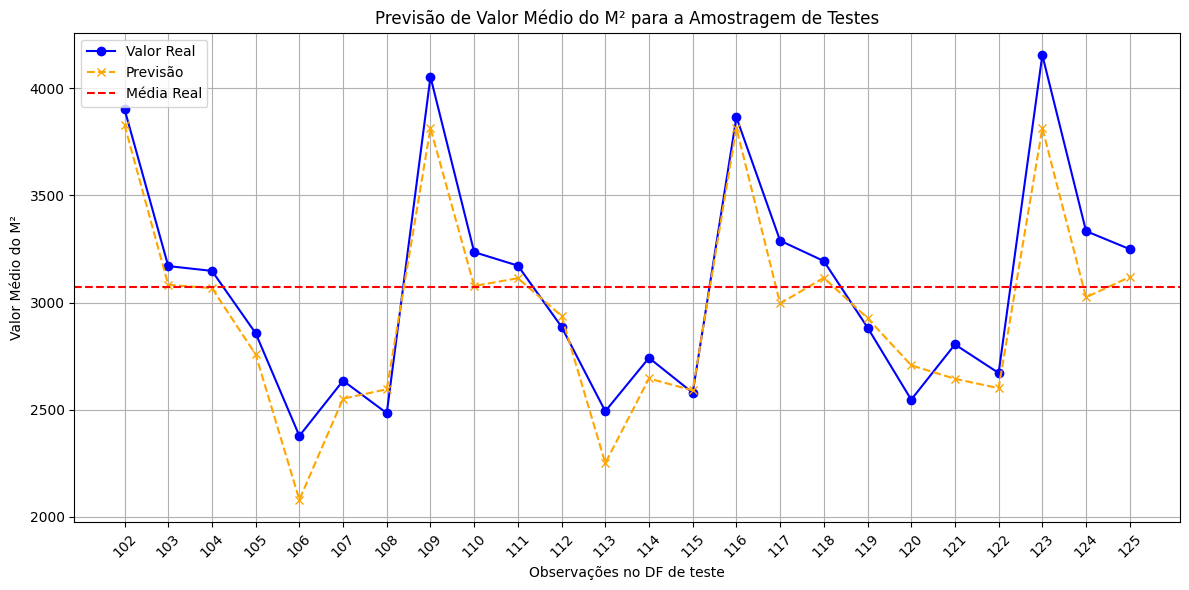

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Visualização das previsões para toda a amostragem de testes
plt.figure(figsize=(12, 6))

# Obtendo todos os valores reais e previstos
real_values = test['media_valor_m2'].values
predicted_values = y_pred

# Plotando os valores reais e previstos
plt.plot(real_values, label='Valor Real', marker='o', linestyle='-', color='blue')
plt.plot(predicted_values, label='Previsão', marker='x', linestyle='--', color='orange')

# Adicionando a linha da média real
plt.axhline(y=np.mean(real_values), color='r', linestyle='--', label='Média Real')

plt.title('Previsão de Valor Médio do M² para a Amostragem de Testes')

# Garantindo que os rótulos do eixo x correspondam aos dados
# Aqui vamos usar o índice do DataFrame 'test' para os rótulos
trimestres = test.index  # Obtendo todos os índices dos trimestres

# Usando todos os trimestres como rótulos
plt.xticks(ticks=np.arange(len(trimestres)), labels=trimestres, rotation=45)

plt.xlabel('Observações no DF de teste')
plt.ylabel('Valor Médio do M²')
plt.legend()
plt.grid()
plt.tight_layout()  # Ajusta o layout para não cortar os rótulos
plt.show()


# 7  - Análise do modelo



## 7.1 - Análise de Correlação

Uma maneira de avaliar a importância das features é através da análise de correlação. Você pode calcular a correlação entre cada feature e a variável alvo. Isso pode ajudar a identificar features que não têm uma relação significativa com a variável alvo.

## 7.1 - Métricas de Avaliação

Após fazer previsões no conjunto de teste, calcule métricas de avaliação para entender a performance do modelo.
Algumas métricas importantes incluem:

## 8.1.1 - Métricas de Avaliação (MSE,RMSE e MAE)

- Erro Quadrático Médio (MSE): Mede a média dos erros ao quadrado.

- Raiz do Erro Quadrático Médio (RMSE): A raiz quadrada do MSE, que traz a métrica de volta à mesma unidade que a variável alvo.

- Erro Absoluto Médio (MAE): Mede a média dos erros absolutos.

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cálculo das métricas
mse = mean_squared_error(test['media_valor_m2'], y_pred)
rmse = mean_squared_error(test['media_valor_m2'], y_pred, squared=False)
mae = mean_absolute_error(test['media_valor_m2'], y_pred)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")



MSE: 28135.91, RMSE: 167.74, MAE: 138.62


/Users/calicojack/Library/CloudStorage/GoogleDrive-romeuivolela@gmail.com/My Drive/Personal/Education/FIAP/Development/fiap_tech_challenge_03/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 7.2 - Resultado (MSE,RMSE e MAE)

Resultado:

- Erro Quadrático Médio (MSE): 12854.10

- Raiz do Erro Quadrático Médio (RMSE): 113.38

- Erro Absoluto Médio (MAE): 88.27

Desempenho do Modelo: Com esses valores, parece que seu modelo tem um desempenho decente. 

Um RMSE de 113.38 e um MAE de 88.27 indicam que as previsões estão relativamente próximas dos valores reais. 

A comparação entre o RMSE e o MAE pode indicar que o modelo não está muito influenciado por outliers, já que o MAE é significativamente menor que o RMSE, que penaliza mais os erros maiores.

## 7.3 - Validação Cruzada

Descrição: Esta técnica envolve dividir os dados em várias partes (folds) e treinar e testar o modelo em diferentes combinações. 
A validação cruzada k-fold é uma abordagem comum.

In [15]:
from sklearn.model_selection import cross_val_score

model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=20, scoring='neg_mean_squared_error')
mse_scores = -scores
print(f"MSE em cada fold: {mse_scores}")
print(f"MSE médio: {mse_scores.mean()}")


MSE em cada fold: [179779.67769139  49447.89948739  60115.31390988 336785.95589846
 304783.19013663  69445.71278947  19076.45918632  23747.85655847
  16284.99387456  14078.15722899  16807.60634051  26920.503637
  56043.49880973  29597.71342504  26770.44395778  18337.55971901
  41232.25549002  14984.49508179  28792.39706726 542565.81719883]
MSE médio: 93779.87537442613


## 7.4 - Calcular os Resíduos

Os resíduos são as diferenças entre os valores observados e os valores previstos pelo modelo. 

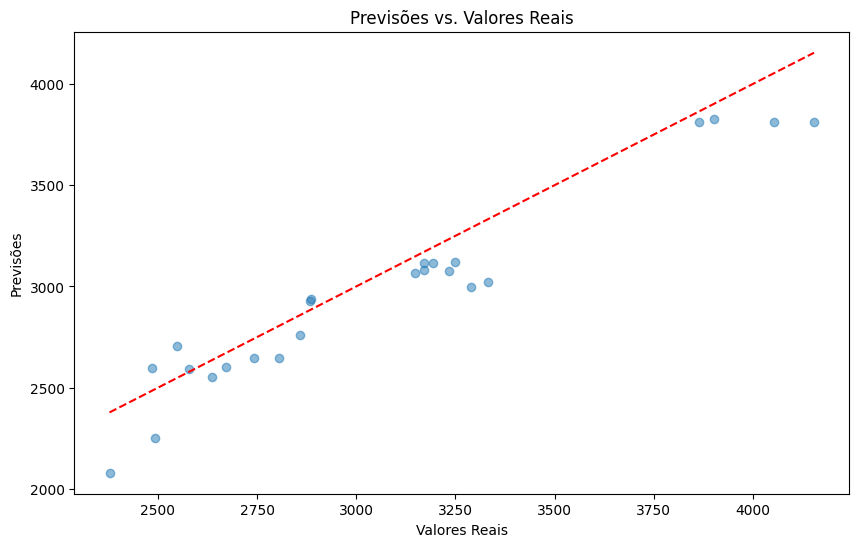

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linha y=x
plt.title('Previsões vs. Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.show()


# 8 - Previsão Futura


/Users/calicojack/Library/CloudStorage/GoogleDrive-romeuivolela@gmail.com/My Drive/Personal/Education/FIAP/Development/fiap_tech_challenge_03/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/calicojack/Library/CloudStorage/GoogleDrive-romeuivolela@gmail.com/My Drive/Personal/Education/FIAP/Development/fiap_tech_challenge_03/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/calicojack/Library/CloudStorage/GoogleDrive-romeuivolela@gmail.com/My Drive/Personal/Education/FIAP/Development/fiap_tech_challenge_03/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/calicojack/Library/CloudStorage/GoogleDrive-romeuivole

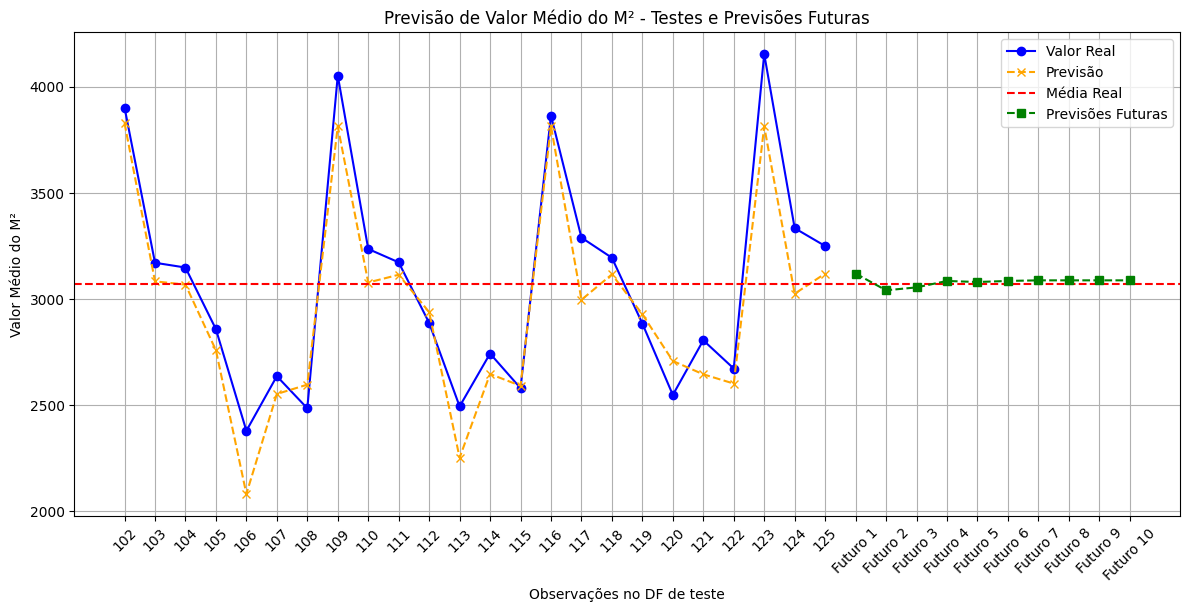

In [18]:
import matplotlib.pyplot as plt
import numpy as np


# Número de previsões futuras
n_futuros = 10

# Previsões futuras (usando o código que você tem para previsões futuras)
future_predictions = []  # Lista para armazenar as previsões futuras
current_data = X_test.iloc[-1].values.reshape(1, -1)  # Obtendo os dados da última observação

# Supondo que você tenha as colunas de lag definidas
lag_columns = [f'media_valor_m2_lag_{i}' for i in range(1, 8)]  # Ajuste conforme suas colunas de lag

for t in range(n_futuros):
    future_pred = grid_search.predict(current_data)  # Fazendo a previsão
    future_predictions.append(future_pred[0])  # Armazenando a previsão
    
    # Atualizando current_data com o novo valor previsto
    current_data[0, -1] = future_pred[0]  # Supondo que a última coluna é a que estamos prevendo
    
    # Atualizando os lag para o próximo loop
    for i in range(len(lag_columns) - 1):
        current_data[0, i] = current_data[0, i + 1]  # Deslocando os valores de lag
    current_data[0, len(lag_columns) - 1] = future_pred[0]  # O novo valor previsto se torna o último lag

# Visualização das previsões para toda a amostragem de testes
plt.figure(figsize=(12, 6))

# Obtendo todos os valores reais e previstos
real_values = test['media_valor_m2'].values
predicted_values = y_pred

# Plotando os valores reais e previstos
plt.plot(real_values, label='Valor Real', marker='o', linestyle='-', color='blue')
plt.plot(predicted_values, label='Previsão', marker='x', linestyle='--', color='orange')

# Adicionando a linha da média real
plt.axhline(y=np.mean(real_values), color='r', linestyle='--', label='Média Real')

# Concatenando as previsões futuras
predicted_values_extended = np.concatenate((predicted_values, future_predictions))


# Garantindo que os rótulos do eixo x correspondam aos dados
trimestres = test.index  # Obtendo todos os índices dos trimestres

# Usando todos os trimestres como rótulos e adicionando rótulos para os futuros
future_labels = ['Futuro {}'.format(i) for i in range(1, n_futuros + 1)]
all_labels = np.concatenate((trimestres, future_labels))

plt.xticks(ticks=np.arange(len(all_labels)), labels=all_labels, rotation=45)

plt.xlabel('Observações no DF de teste')
plt.ylabel('Valor Médio do M²')
plt.plot(np.arange(len(real_values), len(real_values) + n_futuros), future_predictions, label='Previsões Futuras', marker='s', linestyle='--', color='green')
plt.legend()
plt.grid()
plt.tight_layout()  # Ajusta o layout para não cortar os rótulos
plt.title('Previsão de Valor Médio do M² - Testes e Previsões Futuras')
plt.show()
